# --------------------------  CVA Avec Modèle de Jump  ------------------------


# I- process du taux de change avec saut proportionnel et intensité stochastique

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

Le modèle à sauts  ${X_{t}}$ pour le taux change est  $${X_{t}}= {X_{t}}^B{M_{t}}^J$$ ${M_{t}}^J$  est un processus à sauts indépendant de ${X_{t}}^B$ et vérifiant : $${M_{t}}^J=(1+J_{\{t\geqslant\tau\}t})\exp(-\lambda J(min(t,\tau)))$$

In [7]:
# FX avec intensité constante
def Processus_jump_multi_Int_Const(X0,t,lamda,J):
    sigmaX,r=0.2,0.05
    N=10000  # Tragectoire de MC
    
    Int=[0]*N  #Intégrale de l'intensité
    U=np.random.standard_normal(N)  # N trajectoire de MC
    Uniform=np.random.uniform(0,1,N) # N uniforme pour déterminer l'instant de défaut
    Tho=0   # Instant de défaut
    Xt=[]   # Valeur du process
    
    for i in range(N):
        Xb=X0*np.exp((r-0.5*sigmaX**2)*t+sigmaX*np.sqrt(t)*U[i])
        Tho=-np.log(1-Uniform[i])/lamda # car l'instant de défaut est un processus de poisson d'intensité constante lamda
        if Tho>t:  # L'instant de défaut est supérieur à t
            Xt.append(Xb*np.exp(-lamda*J*t))
        else:
            Xt.append(Xb*(1+J)*np.exp(-lamda*J*Tho))
    MonteCarlo_value=sum(Xt)/N
    
    return MonteCarlo_value

In [8]:
# Compilation des valeurs du FX pour 100 valeurs de t entre [0,T]
X0=1.14
t=0
lamda=0.1
J=0.1
T=[i/100 for i in range(100)]
FX=[Processus_jump_multi_Int_Const(X0,t,lamda,J) for t in T]

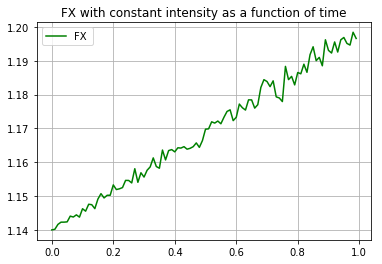

In [13]:
# FX en fonction du temps
T=[i/100 for i in range(100)]
plt.plot(T,FX,'g',label='FX ')
plt.title('FX with constant intensity as a function of time')
plt.grid()
plt.legend()
plt.show()

Le modèle à sauts  ${X_{t}}$ pour le taux change est  $${X_{t}}= {X_{t}}^B{M_{t}}^J$$ ${M_{t}}^J$  est un processus à sauts indépendant de ${X_{t}}^B$ et vérifiant : 
 $${dM_{t}}^J={J_{t}}^A\mathbb{1}_{\{t\leqslant \tau\}}{M_{t-}}^J(dN_{t}-\lambda_{t}dt)$$
  Avec ${M_{0}}^J=1$  et  ${J_{t}}^A$ est une taille de saut proportionnel éventuellement dépendante du temps. Ici, on le considère constant:
  $${M_{t}}^J=(1+J\mathbb{1}_{\{t\leqslant \tau\}})\exp(-J\int_{0}^{min(t,\tau)}\lambda_{u})$$

In [17]:
# FX avec intensité stochastique
def Processus_jump_multi_Int_Sto(X0,T,cor,J):
    sigmaX,sigmaL=0.2,0.2
    Lamda0=1
    N=10000  # Tragectoire de MC
    M= 100  # Subdivision de l'intervalle de temps
    
    Xt=0
    Uniforme=np.random.uniform(0,1,N)
    for i in range(N):
        t,Int=0,0
        # Détermination de l'instant de défaut 
        while t<=T:
            t+=T/M
            #Calcul de St et Lambdat qui sont corrélés 
            V,W=np.random.multivariate_normal([0,0],[[1,cor],[cor,1]],1).T # 2 normales corrélées
            Xbt=X0*np.exp((-0.5*sigmaX**2)*t+sigmaX*np.sqrt(t)*W)
            Lamdat=Lamda0*np.exp((-0.5*sigmaL**2)*t+sigmaL*np.sqrt(t)*V)
            Int+=Lamdat*T/M  #Intégrale de l'intensité
            # Détermination de l'instant de défaut
            if Uniforme[i]<=1-np.exp(-Int):
                Tho=t
                X=Xbt*(1+J)*np.exp(-Int*J)
                break
        if t>T: # Le cas où il n'y a pas défaut
            X=Xbt*np.exp(-Int*J)
        Xt+=X/N # CVA est un espérance du payoff à l'instant de défaut
    return Xt

In [18]:
Processus_jump_multi_Int_Sto(1.14,1,0.5,0.1)

array([1.14551884])

In [8]:
# FX avec intensité stochastique conditionnel l'instant de défaut en t
def InLambda(Lamda0,sigmaL,t): # Calcul d'intégrale entre 0 et t
    N=10000 #Itération MC
    M=500 # Subdivision pour intégrale entre 0 et t
    LamdaRN=0
    # Calcul de l'intégrale de l'intensité
    for i in range(1,M):
        Ti=i*t/M
        W=np.random.standard_normal(N)
        Lamda=0
        for j in range(N):
            Lamda+=np.exp(-Ti*sigmaL**2/2+sigmaL*np.sqrt(Ti)*W[j])
        LamdaRN+=Lamda/N
    LamdaRN*=Lamda0*t/N
    
    return LamdaRN
    
def FX(cor,t,J):
    X0,Lamda0=1.14,1
    sigmaX,sigmaL=0.17,0.2
    N=10000 #Itération MC
    LamdaRN=InLambda(Lamda0,sigmaL,t)
    # Faire apparaître la corrélation entre les deux browniens
    V,W=np.random.multivariate_normal([0,0],[[1,cor],[cor,1]],N).T
    x=0
    for i in range(N):
        x+=(sigmaX*np.sqrt(t)*V[i]-J*Lamda0*np.exp(-t*sigmaL**2/2+sigmaL*np.sqrt(t)*W[i]))/N
    x=-t*sigmaX**2/2+x-J*LamdaRN
    #FX avec jump
    Xt=(1+J)*X0*np.exp(x)
    return Xt  
        

In [9]:
Tho=0.5 # Espérance de l'instant de défaut
FX(0.5,0.5,0.1)

1.1227715523417061

# II- Implementation de la CVA avec MC

In [2]:
def CVA_WWR(X0,T,cor,J,sigmaL):
    sigmaX,K,r,Lamda0=0.1,100,0.05,0.03
    N=10000  # Tragectoire de MC
    M= 1000  # Subdivision de l'intervalle de temps
    
    Lamda=[[]]*M
    Int=[[]]*M  #Intégrale de l'intensité
    Xt=[[]]*M  # FX
    
    #Initialisation
    V,W=np.random.multivariate_normal([0,0],[[1,cor],[cor,1]],N).T # N trajectoire de MC 
    for j in range(N):
        x=Lamda0*np.exp((-0.5*sigmaL**2)*T/M+sigmaL*np.sqrt(T/M)*V[j])
        Lamda[0].append(x)
        Int[0].append(x*T/M)
        s=X0*np.exp((-0.5*sigmaX**2)*T/M+sigmaX*np.sqrt(T/M)*W[j])
        Xt[0].append(s)
    
    #La suite du tableau avec récurrence
    for i in range(1,M):
        V,W=np.random.multivariate_normal([0,0],[[1,cor],[cor,1]],N).T # N trajectoire de MC 
        for j in range(N):
            x=Lamda[i-1][j]*np.exp((-0.5*sigmaL**2)*T/M+sigmaL*np.sqrt(T/M)*V[j])
            Lamda[i].append(x)
            Int[i].append(Int[i-1][j]+x*T/M)
            s=Xt[i-1][j]*np.exp((-0.5*sigmaX**2)*T/M+sigmaX*np.sqrt(T/M)*W[j])
            Xt[i].append(s)
            
    #Calcul CVA
    CVA=0
    for i in range(M):
        #Espérance de la Fonction densité de l'instant de défaut à tj multipliée par le FX
        densite=sum([Xt[i][j]*Lamda[i][j]*np.exp(-Int[i][j]*(1+J)) for j in range(N)])/N
        #CVA en Riemann
        CVA+=(1+J)*densite*T/M
    return CVA

In [21]:
# Calcul de la CVA_WWR
X0,T,cor,J,sigmaL=1.14,5,0.5,0.1,0.2
start=time.time()
y=CVA_WWR(X0,T,cor,J,sigmaL)
end=time.time()
print(end-start,y)

205.32682609558105 0.17100195365684379


In [22]:
# le ratio CVA_WWR/CVA_IND
CVA_WWR(X0,T,cor,J,sigmaL)/CVA_WWR(X0,T,0,0,0)

0.9999084768397155

# III- Approximation du ration CVA (WWR/IND)

On peut montrer que $$\frac{CVA_{WWR}}{CVA_{IND}}\approx(1+J)[1+\frac{1}{2}\rho_{X,\lambda}\sigma_{X}\sigma_{\lambda}T-\frac{1}{2}J\lambda_{0}T]$$

In [18]:
# Approximation du ratio CVA_WWR/CVA_IND pour sigmaL faible
def Ratio_App(T,cor,J,sigmaL):
    Lamda0,sigmaX=0.01,0.17
    r=(1-np.exp(-(1+J)*Lamda0*T))/(1-np.exp(-Lamda0*T))+0.5*(1+J)*Lamda0*cor*sigmaL*sigmaX*np.exp(-(1+J)*Lamda0*T)*T**2
    return r

In [20]:
X0,T,cor,J,sigmaL=1.14,5,0.5,0.1,0.2
Ratio_App(T,cor,J,sigmaL)

1.099489845246897

In [12]:
# Ratio des deux CVA
def Ratio_CVA(X0,T,cor,J,sigmaL):
    return CVA_WWR(X0,T,cor,J,sigmaL)/CVA_WWR(X0,T,0,0,0)

In [19]:
Ratio_App(T,cor,J,sigmaL)/Ratio_CVA(X0,T,cor,J,sigmaL)

1.099554620054544

On remarque que Ratio_App est une bonne approximation du ratio CVA_WWR/CVA_IND

# IV- Influence du Jump et de la volatilité sur le ratio CVA

 Paramètres du modèle:  T = 5, ρ = 0.2, σX = 0.1, and λ0 = 0.03.

In [13]:
X0,T,cor=1.14,5,0.2
J=[i*0.2/100 for i in range(16,101)]     # Liste des Jump
sigmaL=[i*0.5/100 for i in range(101) ]  # Liste des volatités pour l'intensité de défaut
X,Y=[],[]

# Ratio CVA avec volatilité de défaut nulle
for j in J:
    start=time.time()
    x=Ratio_CVA(X0,T,cor,j,0)# CVA_corr(cor,sigmaL=0,J)/CVA_ind(sigmaL=0)
    X.append(x)
    end=time.time()
    print('Ratio pour saut= ', j,'est: ', x, ' temps execution: ', end-start, 'la liste de toute les valeurs: ',X)

# Ratio CVA avec Jump nul
for sig in sigmaL:
    start=time.time()
    x=Ratio_CVA(X0,T,cor,0,sig)  # CVA_corr(cor,sigmaL,J=0)/CVA_ind(sigmaL)
    Y.append(x)
    end=time.time()
    print('Ratio pour sigma= ', sig,'est: ', x, ' temps execution: ', end-start, 'la liste de toute les valeurs: ',Y)


Ratio pour saut=  0.032 est:  0.9998559085093819  temps execution:  188.59374713897705 la liste de toute les valeurs:  [0.9998559085093819]
Ratio pour saut=  0.034 est:  1.0001756156226687  temps execution:  190.09266257286072 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687]
Ratio pour saut=  0.036000000000000004 est:  0.9999978740852893  temps execution:  189.661639213562 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893]
Ratio pour saut=  0.038000000000000006 est:  1.0001480062168433  temps execution:  187.52685260772705 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433]
Ratio pour saut=  0.04 est:  0.9998459933039419  temps execution:  199.33067178726196 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419]
Ratio pour saut=  0.042 est:  0.9999290153781403  temps execution:  190.2

Ratio pour saut=  0.07800000000000001 est:  1.0000133657739425  temps execution:  187.01299738883972 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425]
Ratio pour saut=  0.08 est:  1.0000104931696499  temps execution:  187.0333321094513 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.000000570

Ratio pour saut=  0.10200000000000001 est:  0.9999772586476375  temps execution:  186.5884199142456 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375]
Ratio pour saut=  0.10400000000000001 est:  1.0000620373374394  temps execution:  187.9846637248993 la liste de toute les valeurs:  [0.9998559085093819,

Ratio pour saut=  0.12 est:  1.0000910328285817  temps execution:  186.70547533035278 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478158248, 1.00009

Ratio pour saut=  0.136 est:  0.9999493306246745  temps execution:  185.6306447982788 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478158248, 1.00009

Ratio pour saut=  0.15 est:  0.999872757516928  temps execution:  186.77690076828003 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478158248, 1.000091

Ratio pour saut=  0.16400000000000003 est:  0.9998857661285425  temps execution:  187.24661350250244 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478

Ratio pour saut=  0.17600000000000002 est:  1.0000054091635713  temps execution:  190.80690360069275 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478

Ratio pour saut=  0.188 est:  0.9999320024945608  temps execution:  186.1598756313324 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478158248, 1.00009

Ratio pour saut=  0.198 est:  0.9998375331334417  temps execution:  186.08696389198303 la liste de toute les valeurs:  [0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478158248, 1.0000

Ratio pour sigma=  0.08 est:  0.9999967174393724  temps execution:  178.45450806617737 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724]
Ratio pour sigma=  0.085 est:  1.0000660331547484  temps execution:  180.2148163318634 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484]
Ratio pour sigma=  0.09 est:  0.9999109112562514  temps execution:

Ratio pour sigma=  0.15 est:  0.999767655169024  temps execution:  181.91262316703796 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024]
Ratio pour sigma=  0.155 est:  1.0001379436060511  temps execution:  178.45847940444946 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.99

Ratio pour sigma=  0.2 est:  0.9999048388372336  temps execution:  180.28127694129944 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336]
Ratio pour sigma=  0.205 est:  1.0000338149678771  temps execution

Ratio pour sigma=  0.245 est:  0.9998343289232152  temps execution:  179.10426998138428 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.999

Ratio pour sigma=  0.28 est:  0.9999320352450722  temps execution:  179.36665558815002 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.9999

Ratio pour sigma=  0.315 est:  0.9996583949361323  temps execution:  181.30056190490723 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.999

Ratio pour sigma=  0.345 est:  0.9993565802002644  temps execution:  180.14041447639465 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.999

Ratio pour sigma=  0.375 est:  0.9997079036696007  temps execution:  198.02817583084106 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.999

Ratio pour sigma=  0.4 est:  0.9995635844238011  temps execution:  179.74758338928223 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.99996

Ratio pour sigma=  0.425 est:  0.9999853296328232  temps execution:  180.54267120361328 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.999

Ratio pour sigma=  0.45 est:  1.0007175138099984  temps execution:  179.59779024124146 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.9999

Ratio pour sigma=  0.475 est:  0.9991053530232019  temps execution:  181.33081650733948 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.999

Ratio pour sigma=  0.495 est:  0.9999192375175268  temps execution:  400.91715455055237 la liste de toute les valeurs:  [1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.999

# a- Processus pur saut

In [25]:
Value=L+[0.9998559085093819, 1.0001756156226687, 0.9999978740852893, 1.0001480062168433, 0.9998459933039419, 0.9999290153781403, 1.0000858019960204, 0.9999944226241216, 0.9999673992456497, 0.9999447821776479, 0.9999647310281657, 1.000058345695003, 0.9998845879705264, 1.0000005703520727, 0.9997975582881178, 1.0000239532675634, 0.999889413635527, 1.0000463047043047, 0.9999618163115438, 0.9999091189901735, 0.9999901111167836, 0.9999413779999727, 0.9999463541113153, 1.0000133657739425, 1.0000104931696499, 0.9999024156694962, 1.000042760256009, 0.9998722144639108, 1.0000320919496481, 1.0000954707397094, 0.999960707066535, 0.9999600696937353, 0.9999374702122558, 0.999806196640889, 0.9999107162291262, 0.9999772586476375, 1.0000620373374394, 1.0000106913901103, 0.9999149593631258, 0.9999856560823502, 0.9999654628930209, 0.9999295288475085, 1.000137761049562, 0.9999380478158248, 1.0000910328285817, 1.0001343322480787, 1.0000843014477683, 1.000035631882204, 0.9998825067323643, 0.9997685154965095, 1.000018911365392, 1.0000234427043873, 0.9999493306246745, 0.9999381176439045, 0.9999824866571081, 0.9999542279855019, 1.000075417188415, 0.9999479690845846, 0.9998201978064168, 0.999872757516928, 0.9997290689039506, 0.9998418743728487, 0.9998620797759115, 0.9999113390969623, 0.9998463026129365, 0.9998610406318312, 0.9998857661285425, 1.0001249103264929, 1.000019653976004, 0.9999404966012031, 0.9998849178101719, 0.999861022906871, 1.0000054091635713, 0.9997749107652182, 1.0000607374829138, 1.0002194876738886, 0.9998660748418986, 0.9998637294099287, 0.9999320024945608, 0.9999844375445925, 1.0000176112428336, 1.0000752507277437, 0.9999728287333567, 0.9998375331334417, 0.9998473695710134]

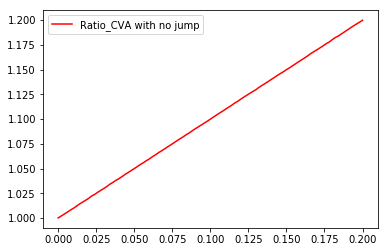

In [26]:
# Pur saut==sans volatilité
J=[i*0.2/100 for i in range(101)]
Ratio_CVA_sansvol=[(1+J[i])*Value[i] for i in range(101)]
plt.plot(J,Ratio_CVA_sansvol,"r",label='Ratio_CVA with no jump')
plt.legend()
plt.show()

# b- Processus pur intensité stochastique

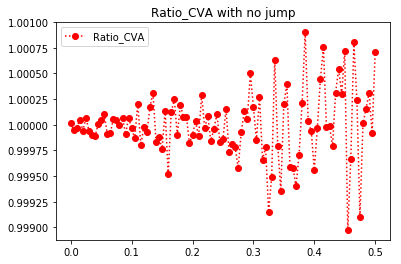

In [15]:
#Pur intensité stochastique == sans jump
K=[1.0000161484625878, 0.9999452442797367, 0.9999689768107359, 1.0000514098486741, 0.9999414693805668, 1.0000707395655712, 0.9999355626911155, 0.999899765781987, 0.9998877697092836, 1.0000085751496435, 1.000048034814662, 1.0001003751295374, 0.9999125087905141, 0.9999247947322224, 1.000054936850004, 1.0000477014395976, 0.9999967174393724, 1.0000660331547484, 0.9999109112562514, 1.0000688975525822, 0.9999646921474936, 0.9998674830174664, 1.0002062899177588, 0.9998025085922365, 0.9999792903315777, 0.9999268368466783, 1.0001702551764065, 1.0003142855446694, 0.9998347297224786, 0.9998772725444441, 0.999767655169024, 1.0001379436060511, 0.999516699287427, 1.0001243082371598, 1.0002517615558388, 0.9999027731011341, 1.0001908595506337, 1.0000749358369383, 1.0000760990935553, 0.9998204879577778, 0.9999048388372336, 1.0000338149678771, 0.9998861229672471, 1.000292308839256, 0.9999666648871972, 1.000090074856011, 0.9998445722745399, 0.9999543697145792, 1.000103995416621, 0.9998343289232152, 0.9998615809220782, 1.0001514702961243, 0.9997320548112507, 0.9998145721154036, 0.9997818211775547, 0.9995777641795786, 0.9999320352450722, 1.0001298427804481, 1.0000612439415004, 1.0005021544359693, 1.0001713005058601, 0.9998490359801926, 1.0002752365276548, 0.9996583949361323, 0.9997822573283306, 0.999150702592922, 0.9994954055658316, 1.0006304666622932, 0.9997974598479451, 0.9993565802002644, 1.000201694573817, 1.0003994534817733, 0.9995891201445944, 0.9995804758292763, 0.9994021936863446, 0.9997079036696007, 1.0002083034074767, 1.0009020664853, 1.0000367759607747, 0.999936875754706, 0.9995635844238011, 0.9999649324978971, 1.0004424113749906, 1.000757184579157, 0.9999805347739201, 0.9999853296328232, 0.9997940434952275, 1.0003117718275056, 1.000544025769806, 1.0003016425448743, 1.0007175138099984, 0.9989754713313447, 0.999669633646474, 1.0008037331592627, 1.000239028587041, 0.9991053530232019, 1.0000130308830428, 1.000153599629284, 1.0003142538716767, 0.9999192375175268, 1.0007064484715869]
sigmaL=[i*0.5/100 for i in range(101)]
plt.plot(sigmaL,K,"r:o",label='Ratio_CVA')
plt.title('Ratio_CVA with no jump')
plt.legend()
plt.show()

# c- Approximation du ratio de la CVA

Evolution de l'approximation du ratio de la CVA en fonction de la volatilité et du jump

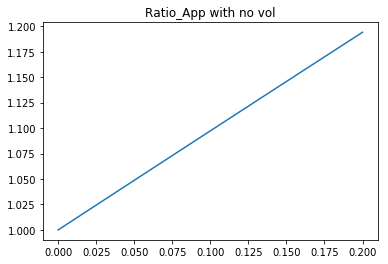

In [38]:
Jump=[i*0.2/100 for i in range(101)]
W=[Ratio_App(T,cor,j,0) for j in Jump]
plt.plot(J,W)
plt.title('Ratio_App with no vol')
plt.show()

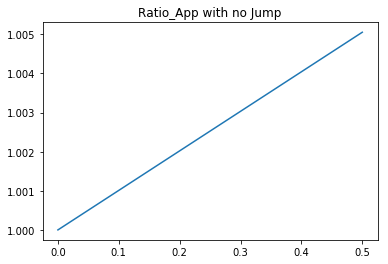

In [39]:
sigmaL=[i*0.5/100 for i in range(101)]
V=[Ratio_App(T,cor,0,sig) for sig in sigmaL]
plt.plot(sigmaL,V)
plt.title('Ratio_App with no Jump')
plt.show()

# V- CVA avec intensité déterministe (constante)

Le taux de change avec intensité constante:
$$X_{t}={X_{t}}^B(1+J)e^{-\lambda Jt}$$

In [5]:
# FX avec intensité constante
def FXD(X0,t,J,Lamda):
    sigmaX=0.17
    N=10000 #Itération MC
    Xt_B=0
    # Calcul de l'éspérance de Xt_B qui suit le modèle de B&S
    W=np.random.standard_normal(N)
    for j in range(N):
        Xt_B+=np.exp(-t*sigmaX**2/2+sigmaX*np.sqrt(t)*W[j])/N
    Xt=(1+J)*X0*Xt_B*np.exp(-Lamda*J*t)
    return Xt  

Pour une intensité déterministe, on a l'expression suivante:
 $$CVA_{WWR}=(1-R)\int_{0}^{T}B(0,t)\mathbb{E^Q}[(V(t, {X_{t}}^B(1+J)e^{-\lambda Jt}))^{+}]\lambda\exp(-\lambda t)dt$$
 Pour $J=0$, on obtient la formule du CVA indépendante

In [7]:
# CVA_WWR avec intensité stochastique
def CVA_WWR_D(X0,t,J,Lamda):
    M=1000
    CVA=0
    for i in range(1,M+1):
        Ti=i*t/M
        Xt=FXD(X0,Ti,J,Lamda)
        CVA+=Xt*Lamda*np.exp(-Lamda*Ti)*Ti/M
    return CVA

In [8]:
X0,t,J,Lamda=1.14,5,0.1,0.01
FXD(X0,t,J,Lamda)
CVA_WWR_D(X0,t,J,Lamda)

0.03022791468713143

In [11]:
# Calcule CVA_IND en annulant le jump dans la CVA_WWR
start=time.time()
CVA=CVA_WWR_D(X0,t,0,Lamda)
end=time.time()
print(end-start,CVA)

690.289265871048 0.027572539114128224


In [13]:
# Ratio CVA_WWR/CVA_IND
0.027572539114128224/0.03022791468713143

0.9121548541972812

On dérive une approximation pour la CVA basée sur la négligence de la correction du drift $e^{-\lambda J t}$.
 $$CVA \approx (1-R) \int_{0}^{T}\mathbb{E}[D(0,t)V(t,{X_{t}}^B(1+J)^+]\lambda e^{-\lambda t}dt$$
 Si $X_{0}\longrightarrow X_{0}(1+J)$ on a:
 $$CVA_{WWR}(X_{0})\approx CVA_{IND}(X_{0}(1+J))$$

In [12]:
# Ratio CVA_WWR(X0)/CVA_IND(X0(1+J))
def Ratio_CVA_FXD(X0,t,J,Lamda):
    return CVA_WWR_D(X0,t,J,Lamda)/CVA_WWR_D(X0*(1+J),t,0,Lamda)

 # Evolution du ratio selon le jump 

In [14]:
Jump=[-0.1,-0.05,0,0.05,0.1]
Ratio_Jump=[]
for J in Jump:
    start=time.time()
    x=Ratio_CVA_FXD(X0,t,J,Lamda)
    end=time.time()
    Ratio_Jump.append(x)
    print('le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est :',x, "temps d'execution ", end-start, Ratio_Jump)

le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 0.9030490017489491 temps d'execution  657.8746423721313 [0.9030490017489491]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 0.9516349785666288 temps d'execution  705.021965265274 [0.9030490017489491, 0.9516349785666288]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 0.9999377881250919 temps d'execution  726.4715473651886 [0.9030490017489491, 0.9516349785666288, 0.9999377881250919]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 1.0482187125871398 temps d'execution  594.0930688381195 [0.9030490017489491, 0.9516349785666288, 0.9999377881250919, 1.0482187125871398]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 1.0963622727377698 temps d'execution  609.6149199008942 [0.9030490017489491, 0.9516349785666288, 0.9999377881250919, 1.0482187125871398, 1.0963622727377698]


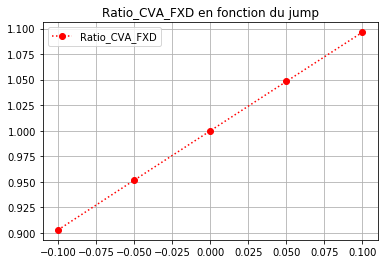

In [42]:
Ratio_CVA_FXD=[0.9030490017489491, 0.9516349785666288, 0.9999377881250919, 1.0482187125871398, 1.0963622727377698]
Jump=[-0.1,-0.05,0,0.05,0.1]
plt.plot(Jump,Ratio_CVA_FXD,"r:o",label='Ratio_CVA_FXD')
plt.legend()
plt.grid()
plt.title("Ratio_CVA_FXD en fonction du jump")
plt.show()

# Evolution du ratio selon lamda

In [15]:
Lambda=[i*0.01 for i in range(1,6)]
Ratio_Lamda=[]
for Lamda in Lambda:
    start=time.time()
    x=Ratio_CVA_FXD(X0,t,J,Lamda)
    end=time.time()
    Ratio_Lamda.append(x)
    print('le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est :',x, "temps d'execution ", end-start,Ratio_Lamda)

le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 1.096303667542408 temps d'execution  676.0813317298889 [1.096303667542408]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 1.0926968330389872 temps d'execution  658.3805639743805 [1.096303667542408, 1.0926968330389872]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 1.0891131638610936 temps d'execution  557.1797256469727 [1.096303667542408, 1.0926968330389872, 1.0891131638610936]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 1.0856127113823095 temps d'execution  546.9739427566528 [1.096303667542408, 1.0926968330389872, 1.0891131638610936, 1.0856127113823095]
le ratio CVA_WWR et CVA_IND avec X0--X0(1+J) est : 1.082121475270276 temps d'execution  574.6194748878479 [1.096303667542408, 1.0926968330389872, 1.0891131638610936, 1.0856127113823095, 1.082121475270276]


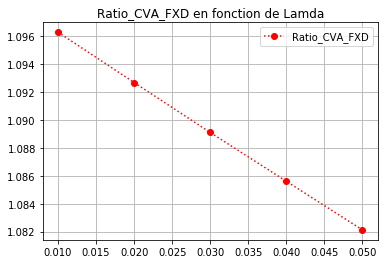

In [43]:
Ratio_Lamda=[1.096303667542408, 1.0926968330389872, 1.0891131638610936, 1.0856127113823095, 1.082121475270276]
Lambda=[i*0.01 for i in range(1,6)]
plt.plot(Lambda,Ratio_Lamda,"r:o",label='Ratio_CVA_FXD')
plt.legend()
plt.grid()
plt.title("Ratio_CVA_FXD en fonction de Lamda")
plt.show()